## LockSense Image Classification

In [ ]:
# Create the necessary directories
!for cat in $(echo 'lock-n-key lock-pick empty'); do echo $cat; mkdir -p "datasets/train/$cat" "datasets/test/$cat"; done

lock-n-key
lock-pick
empty


#### Pre-Processing

First, we need to convert HEIF images into JPEG form.

In [ ]:
from enum import Enum, unique
import os
from PIL import Image
import pyheif

INPUT_PATH = './raw_datasets/test'
OUTPUT_PATH = './datasets/test'


@unique
class ImageFormat(Enum):
    HEIF = 'HEIF'
    JPEG = 'JPEG'
    OTHER = ''

    @classmethod
    def from_ext(self, ext):
        ext = ext.lower()
        if ext in self._ext_map.keys():
            return self._ext_map[ext]
        else:
            return self.OTHER

ImageFormat._ext_map = {
    '.heic': ImageFormat.HEIF,
    '.jpg': ImageFormat.JPEG,
    '.jpeg': ImageFormat.JPEG,
}


def open_heif_image(filepath):
    heif_file = pyheif.read(filepath)
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
    )
    return image


def open_image(filepath):
    return Image.open(filepath)


def remove_prefix(s, prefix):
    return s[len(prefix):] if s.startswith(prefix) else s

def get_output_path(orig_path):
    relative_path = remove_prefix(orig_path, INPUT_PATH)
    return OUTPUT_PATH + relative_path


# def resize_and_save(image, filename):
#     resized_image = image.resize((64, 64))
#     resized_image.save('./images/64x64/%s.jpg' %
#                        filename, ImageFormat.JPEG.value)
#     resized_image.show()

def save(image, path):
    image.save(path)


def process_file(path, filename):
    filepath = os.path.join(path, filename)
    # print("Processing %s..." % filepath)

    (raw_filename, ext) = os.path.splitext(filename)

    image_fmt = ImageFormat.from_ext(ext)
    if image_fmt == ImageFormat.HEIF:
        image = open_heif_image(filepath)
    else:
        image = open_image(filepath)

    # resize_and_save(image, raw_filename)
    output_filepath = "%s/%s.jpg" % (get_output_path(path), raw_filename)
    save(image, output_filepath)


def process_files(path):
    num_files=0
    for entry in os.scandir(path):
        if entry.is_dir():
            process_files(entry.path)
            continue
        process_file(path, entry.name)
        num_files += 1
    print("Processed %d files in %s..." % (num_files, path))

# process_files(INPUT_PATH)

#### Data Augmentation

Code to test & demonstrate various augmentation techniques.

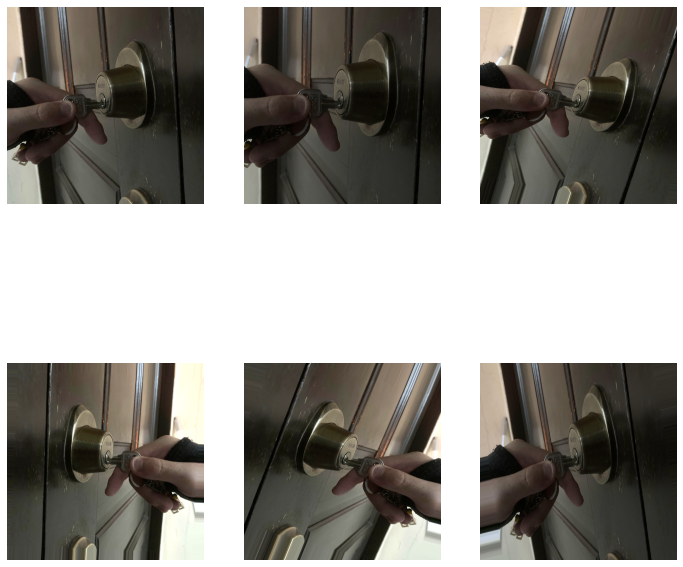

In [ ]:
from numpy import expand_dims
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

img_path = './datasets/train/lock-n-key/IMG_5618.jpg'

img = open_image(img_path)
data = img_to_array(img)
sample = expand_dims(data, 0)

# Specify data augmentation
datagen = ImageDataGenerator(
        brightness_range=(0.5, 1.5),
		# channel_shift_range=30,
		rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

# iterator
aug_iter = datagen.flow(sample, batch_size=1)

# generate samples and plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,12))

# generate batch of images
for i in range(6):
	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	row, col = int(i/3), i%3
	axes[row, col].imshow(image)
	axes[row, col].axis('off')

#### Model Selection: Transfer Learning

- Rationale: (Maybe) insufficient data to train a full model from scratch
- Considerations: Need to find a lightweight model

Links/References:
- [All Keras models](https://keras.io/api/applications/)
- Keras documentation: [Transfer Learning](https://keras.io/guides/transfer_learning/)

Utility functions and constants.

In [ ]:
%run functions.py
%run common.py

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, plot_name):
    # Visualize history
    # Plot history: Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('%s (Loss)' % plot_name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Plot history: Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('%s (Accuracy)' % plot_name)
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model, Model
import numpy as np
import matplotlib.pyplot as plt

images_per_row = 16

def get_layer_outputs_and_names(model, num_selected_layers):
    selected_layers = model.layers[:num_selected_layers]
    layer_outputs = [layer.output for layer in selected_layers] 
    layer_names = [layer.name for layer in selected_layers]
    return layer_outputs, layer_names

def display_image_activations(layer_outputs, layer_names, activations, selected_image):
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[selected_image,
                                                :, :,
                                                col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


# TODO: refactor this to avoid repeated computation when checking multiple images
def visualise_layers(model, num_selected_layers, test_x, selected_image):
    layer_outputs, layer_names = get_layer_outputs_and_names(model, num_selected_layers)

    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(test_x) 

    display_image_activations(layer_outputs, layer_names, activations, selected_image)


In [ ]:
num_classes = 3

input_shape=(224, 224, 3)
target_size=(224, 224)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datasets(train_path, validation_path, target_size):
    # Include data augmentation techniques
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.5, 1.5),
		rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Resize to the required input shape
    batch_size = 8
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


def model_callbacks(model_file, patience=10):
    checkpoint = ModelCheckpoint(model_file)
    earlystopping = EarlyStopping(min_delta=0.001, patience=patience)

    return [checkpoint, earlystopping]


#### MobileNetV2

[Documentation](https://keras.io/api/applications/mobilenet/), for reference.


*** Creating new model.***


9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               256200    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 2,514,787
Trainable params: 256,803
Non-trainable params: 2,257,984
_________________________________________________________________
Found 274 images b

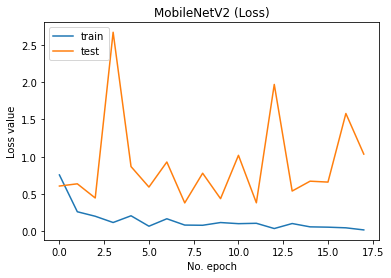

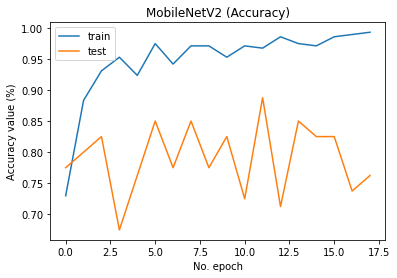

Epoch 1/10
35/35 [==============================] - 127s 4s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1153 - val_accuracy: 0.7750
INFO:tensorflow:Assets written to: mobilenet-transfer.hd5/assets
Epoch 2/10
35/35 [==============================] - 130s 4s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7373 - val_accuracy: 0.8125
INFO:tensorflow:Assets written to: mobilenet-transfer.hd5/assets
Epoch 3/10
35/35 [==============================] - 136s 4s/step - loss: 0.0132 - accuracy: 0.9974 - val_loss: 0.8358 - val_accuracy: 0.8250
INFO:tensorflow:Assets written to: mobilenet-transfer.hd5/assets
Epoch 4/10
35/35 [==============================] - 119s 3s/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 1.1788 - val_accuracy: 0.7750
INFO:tensorflow:Assets written to: mobilenet-transfer.hd5/assets
Epoch 5/10
35/35 [==============================] - 121s 3s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.6550 - val_accuracy: 0.8250
INFO:tensorflow:Assets written to: 

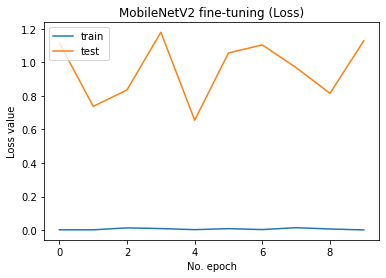

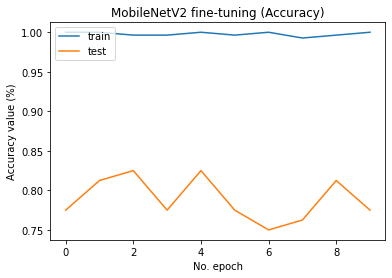

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import os.path

MOBILENET_MODEL_FILE = "mobilenet-transfer.hd5"

num_classes = 3

input_shape=(224, 224, 3)
target_size=(224, 224)

# Create a model if none exists. Freezes all training except in 
# newly attached output layers. We can specify the number of nodes
# in the hidden penultimate layer, and the number of output categories.

def create_model(num_hidden, num_classes):
    base_model = MobileNetV2(
        include_top = False, 
        weights = 'imagenet',
        input_shape=input_shape)

    # Recursively make all layers non-trainable
    base_model.trainable = False

    # Build dense layers for the new model
    inputs = base_model.input
    # Ensure that the base model always runs in inference mode in case of BatchNormalization layers
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_hidden, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs = predictions)

    return model


# Loads an existing model file, then sets only the last 3 layers
# (which we added above) to trainable.

def load_existing(model_file):
    model = load_model(model_file)

    # Set only last 3 layers as trainable
    num_trainable_layers = len(model.layers) - 3
    
    for layer in model.layers[:num_trainable_layers]:
        layer.trainable = False
    
    for layer in model.layers[num_trainable_layers:]:
        layer.trainable = True

    return model


def load_or_create_model(model_file, num_hidden=200):
    if os.path.exists(model_file):
        print("\n*** Existing model file found at %s. Loading.***\n\n" % model_file)
        model = load_existing(model_file)
    else:
        print("\n*** Creating new model.***\n\n")
        model = create_model(num_hidden, num_classes)

    return model


def create_datasets(train_path, validation_path):
    # Include data augmentation techniques
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.5, 1.5),
		rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Resize to the required input shape
    batch_size = 8
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator


def model_callbacks(model_file, patience=10):
    checkpoint = ModelCheckpoint(model_file, save_best_only=True)
    earlystopping = EarlyStopping(min_delta=0.001, patience=patience, restore_best_weights=True)

    return [checkpoint, earlystopping]


def train(model, callbacks, train_generator, validation_generator, epochs=20):
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )

    return history


def train_finetune(model, callbacks, train_generator, validation_generator, epochs=20):
    # Train last two layers for fine tuning
    # TODO: figure out how many layers to train
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True

    model.compile(
        optimizer=SGD(lr=0.00001, momentum=0.9), 
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    history = model.fit(
        train_generator,
        # Let steps per epoch be decided automatically
        # steps_per_epoch=int(steps/batch_size), # each step is one batch
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )

    return history


model = load_or_create_model(MOBILENET_MODEL_FILE)
model.summary()

train_generator, validation_generator = create_datasets(
    train_path='datasets/train', 
    validation_path='datasets/test')

callbacks = model_callbacks(MOBILENET_MODEL_FILE)

history = train(
    model, 
    callbacks,
    train_generator, 
    validation_generator, 
    epochs=50)
plot_history(history, 'MobileNetV2')

history = train_finetune(model, callbacks, train_generator, validation_generator, epochs=10)
plot_history(history, 'MobileNetV2 fine-tuning')


We can also visualise the output at each step.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/patches.py:769: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/shared-libs/python3.7/py/lib/python3.7/site-packages/matplotlib/transforms.py:20

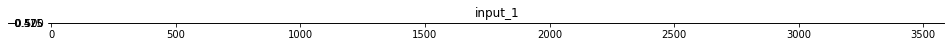

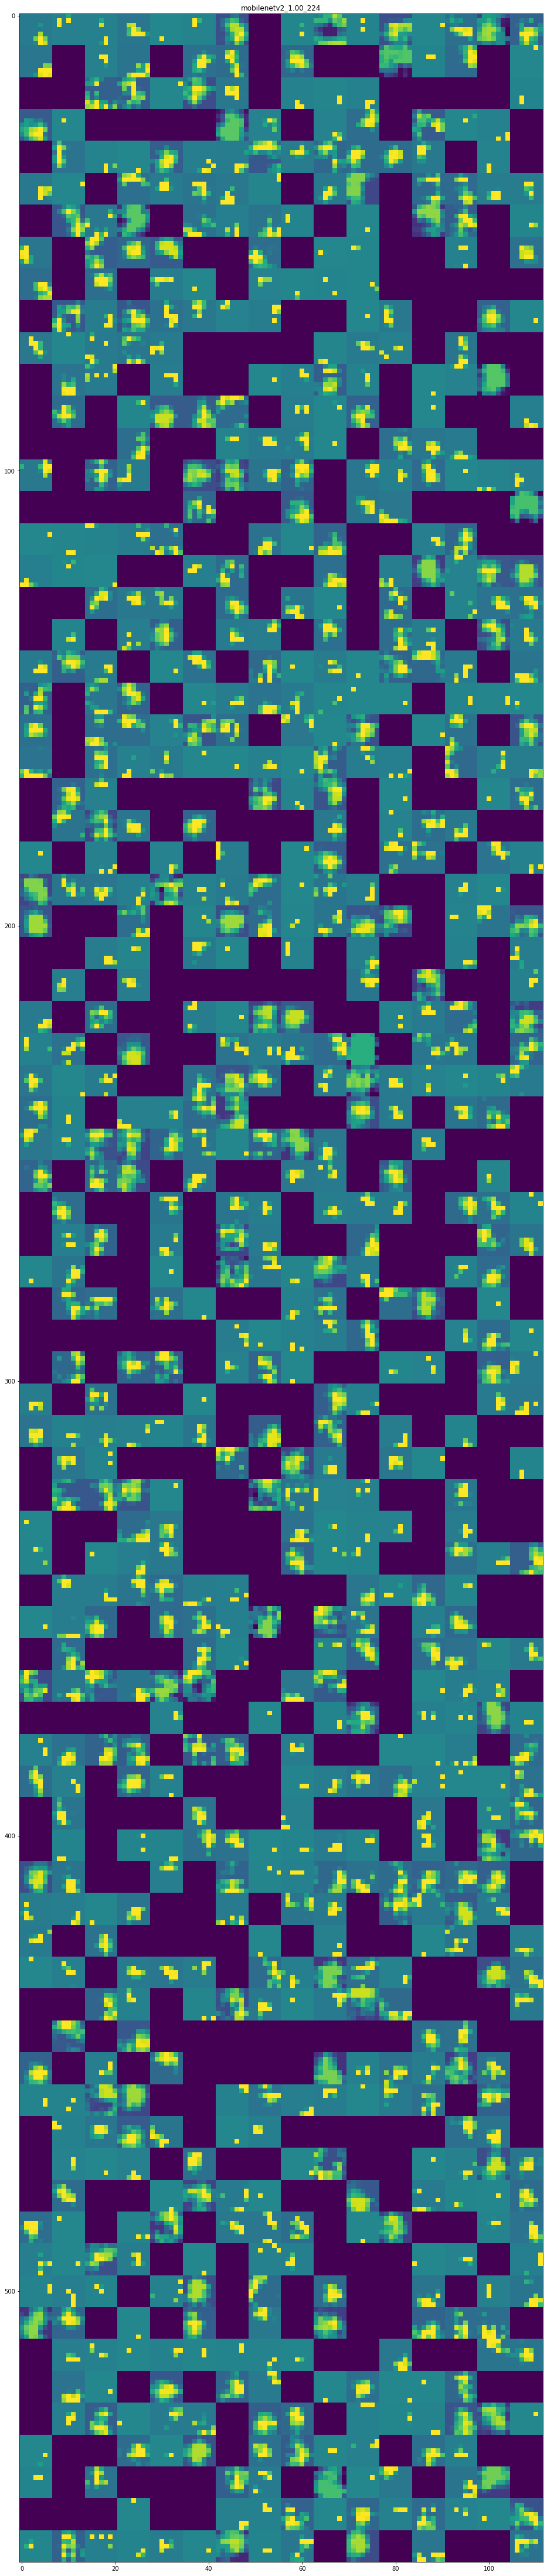

In [ ]:
from numpy import expand_dims
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

model = load_model(MOBILENET_MODEL_FILE)

TEST_IMG_PATH = './datasets/test/lock-n-key/IMG_2934.jpg'
test_img = Image.open(TEST_IMG_PATH).resize(target_size)
data = img_to_array(test_img)
sample = expand_dims(data, 0)

visualise_layers(model, 2, [sample], 0)


#### Convolutional Neural Network (CNN)

We can also try building a (simpler) CNN from scratch.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               12845184  
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 3

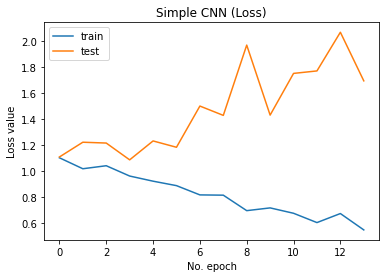

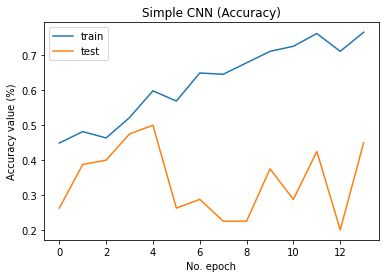

In [ ]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# Functional API definition, for reference:
    # visible = Input(shape=input_shape)
    # pool1 = AveragePooling2D(pool_size=(2, 2))(visible)
    # conv1 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1)
    # pool1 = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(conv1)
    # conv2 = Conv2D(128, kernel_size=(3,3), padding='same')(pool1)
    # pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)
    # flatten = Flatten()(pool2)
    # output = Dense(num_classes, activation = 'softmax')(flatten)


def create_simple_cnn():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        Conv2D(32, kernel_size=(3,3), padding='same'),
        AveragePooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])
    return model


def model_callbacks(model_file, patience=10):
    checkpoint = ModelCheckpoint(model_file, save_best_only=True)
    earlystopping = EarlyStopping(min_delta=0.001, patience=patience, restore_best_weights=True)

    return [checkpoint, earlystopping]


def train_simple_cnn(model, callbacks, train_generator, validation_generator, epochs):
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=SGD(lr = 0.01, decay = 1e-6, momentum = 0.01), 
        metrics = 'accuracy')

    history = model.fit(
        train_generator,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )

    return history

CNN_MODEL_FILE = "simple-cnn.hd5"

cnn_model = create_simple_cnn()
cnn_model.summary()

train_generator, validation_generator = create_datasets(train_path='datasets/train', validation_path='datasets/test')
callbacks = model_callbacks(CNN_MODEL_FILE)

history = train_simple_cnn(cnn_model, callbacks, train_generator, validation_generator, epochs=50)
plot_history(history, "Simple CNN")



#### CNN Architecture

As an experiment, [KerasTuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) is used to find optimal hyperparameters (e.g. learning rate, number of layers) for a CNN.

// TODO: figure out if this is good practice

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddd5f9cd-14c1-4462-aac1-a464a84065be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>